# 🛰️ Classificador de Spoofing em Sinais de GNSS

### **Projeto de Sinais e Sistemas (Parte 2)**

Esse notebook implementa classificadores para detectar sinais GNSS originados por spoofing. As features utilizadas são métricas extraídas de correlações e características retiradas dos sinais dos datasets FGI SpoofRepo e FGI OSNMA, que podem ser analisadas com mais detalhes no notebook da Parte 1 do projeto.

Os modelos implementados e comparados nesse projeto, são:
1. **Random Forest** - Classificador baseado em árvores de decisão
2. **SVM** - Support Vector Machine
3. **MLP** - Multi-Layer Perceptron

## Instalação de bibliotecas necessárias

In [11]:
# Instalação de dependências
%pip install pandas scikit-learn matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


## Importação de bibliotecas necessárias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Carregamento e visão geral do dataset

In [13]:
DATA_PATH = '/home/rc-2d/gnss-spoofing-detection/data/gnss_dataset_labeled.csv'

df = pd.read_csv(DATA_PATH)

print(f"\nShape: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")
print(f"\nDistribuição das classes:")
print(df['label_name'].value_counts())
print(f"\nPrimeiras linhas do dataset:")
df.head()


Shape: (100, 11)

Colunas: ['block_idx', 'time_s', 'best_prn', 'best_doppler', 'best_tau_chips', 'peak_snr', 'peak_raw', 'in_phase_lag', 'correlation_width', 'label', 'label_name']

Distribuição das classes:
label_name
spoofed      50
authentic    50
Name: count, dtype: int64

Primeiras linhas do dataset:


,block_idx,time_s,best_prn,best_doppler,best_tau_chips,peak_snr,peak_raw,in_phase_lag,correlation_width,label,label_name
0,33,0.033,7,1000,928,11.126804,210.439453,-175.0,1,1,spoofed
1,3,0.003,30,3000,80,9.894979,184.342708,0.0,1,1,spoofed
2,20,0.020,30,3000,80,9.085154,173.397884,0.0,2,1,spoofed
3,45,0.045,30,3000,72,10.845030,216.239877,0.0,1,0,authentic
4,44,0.044,30,2500,72,10.360439,209.560662,0.0,1,0,authentic


## Preparação dos dados

In [14]:
# Features usadas na classificação
FEATURE_COLUMNS = ['best_prn', 'best_doppler', 'best_tau_chips', 'peak_snr', 'peak_raw', 'in_phase_lag']
# Label: 0 = authentic, 1 = spoofed
TARGET_COLUMN = 'label'

# Verificar valores ausentes (boa prática)
print("Valores ausentes por coluna:")
print(df[FEATURE_COLUMNS + [TARGET_COLUMN]].isnull().sum())

# Separar features e target
X = df[FEATURE_COLUMNS].values
y = df[TARGET_COLUMN].values

print(f"\nShape das features (X): {X.shape}")
print(f"Shape do target (y): {y.shape}")
print(f"\nDistribuição do target:")
print(f"- Autêntico (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"- Spoofed (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

Valores ausentes por coluna:
best_prn          0
best_doppler      0
best_tau_chips    0
peak_snr          0
peak_raw          0
in_phase_lag      0
label             0
dtype: int64

Shape das features (X): (100, 6)
Shape do target (y): (100,)

Distribuição do target:
- Autêntico (0): 50 (50.0%)
- Spoofed (1): 50 (50.0%)


## Divisão em conjunto de treino e teste

In [15]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

# Normalização das features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures normalizados com sucesso!")

Treino: 80 amostras
Teste: 20 amostras

Features normalizados com sucesso!


## Implementação dos classificadores

In [16]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    
    return metrics, y_pred, y_prob

# Dicionário para armazenar resultados
results = {}

print("Treinando Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
results['Random Forest'], rf_pred, rf_prob = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
print(f"Métricas: {results['Random Forest']}")

print("\nTreinando SVM...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)
results['SVM'], svm_pred, svm_prob = evaluate_model(svm_model, X_test_scaled, y_test, 'SVM')
print(f"Métricas: {results['SVM']}")


Treinando Random Forest...
Métricas: {'model': 'Random Forest', 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}

Treinando SVM...
Métricas: {'model': 'SVM', 'accuracy': 0.7, 'precision': 0.8333333333333334, 'recall': 0.5, 'f1': 0.625, 'roc_auc': 0.79}
Métricas: {'model': 'Random Forest', 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}

Treinando SVM...
Métricas: {'model': 'SVM', 'accuracy': 0.7, 'precision': 0.8333333333333334, 'recall': 0.5, 'f1': 0.625, 'roc_auc': 0.79}


Treinando MLP...
Métricas: {'model': 'MLP', 'accuracy': 0.4, 'precision': 0.42857142857142855, 'recall': 0.6, 'f1': 0.5, 'roc_auc': 0.56}
Epochs treinadas: 23
Loss final: 0.5424
Métricas: {'model': 'MLP', 'accuracy': 0.4, 'precision': 0.42857142857142855, 'recall': 0.6, 'f1': 0.5, 'roc_auc': 0.56}
Epochs treinadas: 23
Loss final: 0.5424


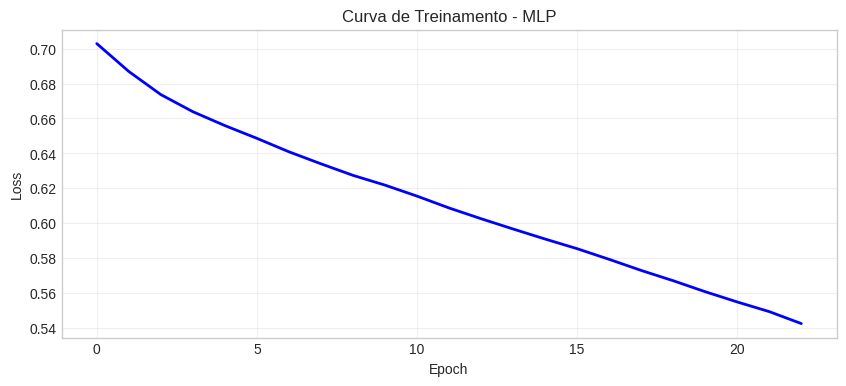

In [17]:
print("Treinando MLP...")

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001, 
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=False
)

mlp_model.fit(X_train_scaled, y_train)
results['MLP'], mlp_pred, mlp_prob = evaluate_model(mlp_model, X_test_scaled, y_test, 'MLP')

print(f"Métricas: {results['MLP']}")
print(f"Epochs treinadas: {mlp_model.n_iter_}")
print(f"Loss final: {mlp_model.loss_:.4f}")

# Plotar curva de perda do MLP
plt.figure(figsize=(10, 4))
plt.plot(mlp_model.loss_curve_, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curva de Treinamento - MLP')
plt.grid(True, alpha=0.3)
plt.show()

## Análise dos resultados e comparação entre os modelos

In [18]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index(drop=True)
metrics_df = metrics_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

print(metrics_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else x))
print("\n")

# Encontrar melhor modelo por métrica
print("Melhores modelos por métrica:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    best_idx = metrics_df[metric].astype(float).idxmax()
    best_model = metrics_df.loc[best_idx, 'model']
    best_value = metrics_df.loc[best_idx, metric]
    print(f"- {metric:12s}: {best_model} ({best_value:.4f})")

        model accuracy precision recall     f1 roc_auc
Random Forest   1.0000    1.0000 1.0000 1.0000  1.0000
          SVM   0.7000    0.8333 0.5000 0.6250  0.7900
          MLP   0.4000    0.4286 0.6000 0.5000  0.5600


Melhores modelos por métrica:
- accuracy    : Random Forest (1.0000)
- precision   : Random Forest (1.0000)
- recall      : Random Forest (1.0000)
- f1          : Random Forest (1.0000)
- roc_auc     : Random Forest (1.0000)


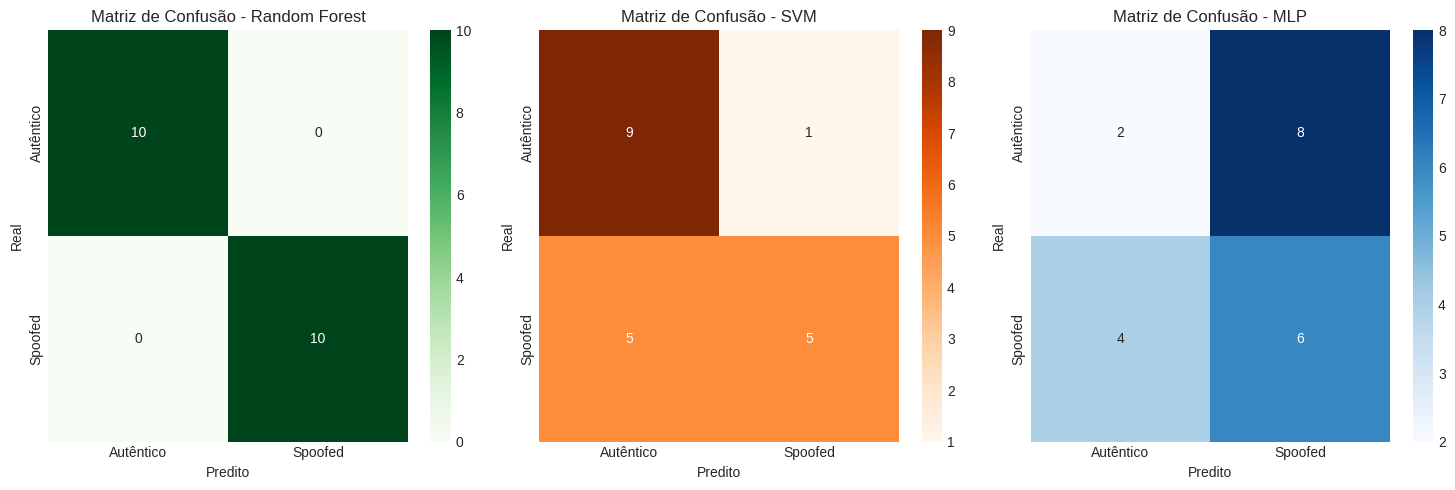


RELATÓRIO DE CLASSIFICAÇÃO - Random Forest (Melhor F1-Score)

              precision    recall  f1-score   support

   Autêntico       1.00      1.00      1.00        10
     Spoofed       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [19]:
# Obter predições de todos os modelos
all_predictions = {
    'Random Forest': rf_pred,
    'SVM': svm_pred,
    'MLP': mlp_pred
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

colors = ['Greens', 'Oranges', 'Blues']

# Plotar matrizes de confusão
for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=colors[idx], ax=axes[idx],
                xticklabels=['Autêntico', 'Spoofed'],
                yticklabels=['Autêntico', 'Spoofed'])
    axes[idx].set_xlabel('Predito')
    axes[idx].set_ylabel('Real')
    axes[idx].set_title(f'Matriz de Confusão - {model_name}')

plt.tight_layout()
plt.show()

# Imprimir relatório de classificação detalhado para o melhor modelo
best_model_name = metrics_df.loc[metrics_df['f1'].astype(float).idxmax(), 'model']
best_pred = all_predictions[best_model_name]

print(f"\nRELATÓRIO DE CLASSIFICAÇÃO - {best_model_name} (Melhor F1-Score)\n")
print(classification_report(y_test, best_pred, target_names=['Autêntico', 'Spoofed']))

## Importância das features no modelo Random Forest

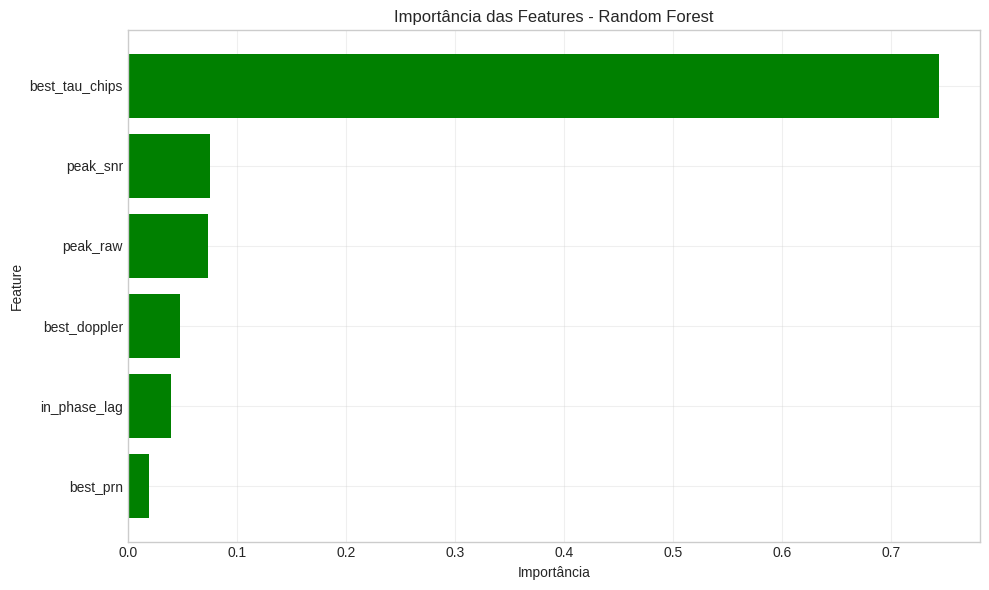


Ranking de Importância das Features:
- best_tau_chips      : 0.7442
- peak_snr            : 0.0758
- peak_raw            : 0.0739
- best_doppler        : 0.0475
- in_phase_lag        : 0.0394
- best_prn            : 0.0192


In [20]:
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='green')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title('Importância das Features - Random Forest')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRanking de Importância das Features:")
for idx, row in feature_importance.iloc[::-1].iterrows():
    print(f"- {row['feature']:20s}: {row['importance']:.4f}")

# 📋 Resumo Técnico: Detecção de Spoofing em Sinais GNSS

---

## 1. Pipeline de Processamento dos Datasets

O processamento dos sinais GNSS foi realizado utilizando os datasets **FGI SpoofRepo** e **FGI OSNMA**, que contêm sinais autênticos e sinais gerados por spoofing, respectivamente. O pipeline de processamento segue as seguintes etapas:

1. **Leitura dos dados brutos**: Os arquivos `.dat` contêm amostras do sinal GNSS em formato `int8`, que são convertidos para `float32` para processamento numérico.

2. **Segmentação em blocos**: O sinal é dividido em blocos de 1 ms (período de um código C/A completo), permitindo análise temporal granular e extração de features por amostra.

3. **Geração das réplicas de código PRN**: Para cada satélite GPS (PRN 1-32), o código C/A é gerado utilizando registradores de deslocamento linear (LFSR) com os taps específicos de cada satélite, seguido de superamostragem para corresponder à taxa de amostragem do receptor.

4. **Busca paralela em Doppler e PRN**: Para cada bloco, realiza-se uma busca exaustiva sobre todas as combinações de PRN (1-32) e frequências Doppler (±5000 Hz em passos de 500 Hz).

5. **Extração de métricas**: Para cada bloco processado, são extraídas as features de correlação e características do sinal.

6. **Rotulagem e exportação**: Os dados processados são rotulados (0 = autêntico, 1 = spoofed) e exportados em formato CSV para treinamento dos classificadores.

---

## 2. Método de Acquisition Utilizado

O método de aquisição implementado é baseado em **correlação no domínio da frequência (FFT-based acquisition)**, uma técnica eficiente para detectar sinais GNSS e estimar o code phase (τ) e a frequência Doppler.

### 2.1 Demodulação do Sinal

O sinal recebido é primeiro demodulado pela frequência central (FC) somada ao Doppler candidato:

$$s_{demod}(t) = s(t) \cdot e^{-j2\pi(f_c + f_d)t}$$

Esta operação translada o sinal para banda base, removendo a componente de frequência intermediária.

### 2.2 Correlação via FFT

A correlação entre o sinal demodulado e a réplica do código PRN é calculada eficientemente no domínio da frequência:

$$R(\tau) = \mathcal{F}^{-1}\left\{ \mathcal{F}\{s_{demod}\} \cdot \mathcal{F}^*\{c_{PRN}\} \right\}$$

O pico de correlação indica:
- **Posição (τ)**: O atraso de código em chips, indicando o code phase
- **Magnitude**: A força do sinal, relacionada à SNR

### 2.3 Normalização pelo Ruído

Para obter uma métrica de SNR robusta, a correlação é normalizada pelo nível de ruído (noise floor), calculado como a mediana dos valores de correlação excluindo uma janela de ±1.5 chips ao redor do pico. Esta abordagem evita que o próprio pico influencie a estimativa de ruído.

---

## 3. Observações e Correções Durante a Implementação

### 3.1 Tratamento de Wrap-Around no Atraso de Código

O atraso τ varia de 0 a 1023 chips de forma cíclica. Ao calcular a variação entre blocos consecutivos (`in_phase_lag`), foi necessário implementar tratamento para o wrap-around:

```python
tau_diff = current_tau - prev_tau
if abs(tau_diff) > PRN_LENGTH / 2:
    tau_diff = tau_diff - np.sign(tau_diff) * PRN_LENGTH
```

### 3.2 Ajuste do Tamanho do Bloco

O número de amostras por bloco foi ajustado para ser múltiplo exato do período do código C/A, garantindo que a correlação cíclica via FFT funcione corretamente:

```python
N_SAMPLES_COHERENT = (N_SAMPLES_COHERENT // SAMPLES_PER_CODE) * SAMPLES_PER_CODE
```

### 3.3 Exclusão do Pico para Estimativa de Ruído

A estimativa inicial do noise floor incluía o próprio pico, resultando em SNR subestimado. A correção implementou exclusão de uma janela ao redor do pico e uso da mediana (mais robusta que a média).

### 3.4 Conversão de Código Bipolar

Os códigos C/A são gerados em formato binário (0, 1) e convertidos para bipolar (-1, +1) para correlação adequada com o sinal modulado em BPSK.

---

## 4. Features Utilizadas e Suas Funções

| Feature | Descrição | Relevância para Detecção de Spoofing |
|---------|-----------|--------------------------------------|
| `best_prn` | PRN do satélite com melhor correlação | Spoofing pode apresentar menor diversidade de PRNs ou PRNs anômalos |
| `best_doppler` | Frequência Doppler estimada (Hz) | Sinais spoofed podem ter Doppler inconsistente ou com saltos abruptos |
| `best_tau_chips` | Atraso de código no pico (chips) | Variações anômalas podem indicar manipulação do sinal |
| `peak_snr` | SNR normalizado no pico de correlação | Spoofing tende a apresentar SNR mais alto e estável (sinal artificial mais "limpo") |
| `peak_raw` | Valor bruto do pico de correlação | Amplitude absoluta do sinal detectado |
| `in_phase_lag` | Variação do atraso entre blocos consecutivos | Saltos abruptos indicam transições não naturais típicas de spoofing |

---

## 5. Resultados do Processamento de Acquisition

### 5.1 Estatísticas do Dataset Processado

Os sinais foram processados em blocos de 1 ms, resultando em:
- **Sinal autêntico (OSNMA)**: 460.000 amostras (460 segundos)
- **Sinal spoofed (TGS)**: Variável conforme duração do arquivo

### 5.2 Métricas de Qualidade

O processamento gerou métricas agregadas incluindo:
- **SNR médio**: Indica a qualidade geral do sinal
- **Diversidade de PRN**: Número de satélites únicos detectados
- **Estabilidade Doppler**: Taxa de variação e presença de saltos
- **Autocorrelação temporal**: Padrões artificiais no SNR

---

## 6. Diferenças Identificadas entre Sinais Autênticos e Spoofed

### 6.1 Características do SNR

| Métrica | Sinal Autêntico | Sinal Spoofed |
|---------|-----------------|---------------|
| SNR médio | Moderado, variável | Geralmente mais alto |
| Coeficiente de variação | Alto (sinal natural) | Baixo (sinal artificial) |
| Distribuição | Ampla, com outliers | Concentrada, mais uniforme |

### 6.2 Comportamento do Doppler

- **Sinais autênticos**: Variação suave e contínua, refletindo o movimento real dos satélites
- **Sinais spoofed**: Podem apresentar saltos abruptos, estabilidade artificial ou padrões inconsistentes com a geometria orbital

### 6.3 Diversidade de PRN

- **Sinais autênticos**: Múltiplos PRNs detectados, refletindo constelação visível
- **Sinais spoofed**: Frequentemente dominados por poucos PRNs ou apresentando PRNs com comportamento sincronizado

### 6.4 Variação Temporal (In-Phase Lag)

- **Sinais autênticos**: Variações pequenas e graduais entre blocos
- **Sinais spoofed**: Podem apresentar saltos de fase abruptos durante transições

---

## 7. Modelos de Machine Learning Utilizados

### 7.1 Random Forest

**Arquitetura**: Ensemble de 100 árvores de decisão com profundidade máxima de 10.

**Pontos Fortes**:
- Robusto a outliers e ruído nos dados
- Não requer normalização das features
- Fornece importância das features nativamente
- Baixo risco de overfitting com configuração adequada
- Excelente para features com diferentes escalas (Doppler em Hz vs. SNR normalizado)

**Pontos Fracos**:
- Pode não capturar relações lineares complexas
- Decisões baseadas em limiares podem perder nuances

**Adequação às Features**: Ideal para as features extraídas, pois captura bem as diferenças categóricas (PRN) e contínuas (SNR, Doppler) sem necessidade de pré-processamento.

### 7.2 SVM (Support Vector Machine)

**Arquitetura**: Kernel RBF com C=1.0 e probabilidades habilitadas.

**Pontos Fortes**:
- Eficaz em espaços de alta dimensionalidade
- Robusto quando há margem clara entre classes
- Kernel RBF captura relações não-lineares

**Pontos Fracos**:
- Sensível à escala das features (requer normalização)
- Custo computacional alto para datasets grandes
- Menos interpretável que Random Forest

**Adequação às Features**: Funciona bem após normalização, especialmente para capturar fronteiras de decisão complexas entre sinais autênticos e spoofed.

### 7.3 MLP (Multi-Layer Perceptron)

**Arquitetura**: Rede neural com camadas (64, 32, 16), ativação ReLU, otimizador Adam, early stopping habilitado.

**Pontos Fortes**:
- Capacidade de aprender representações complexas
- Flexibilidade para capturar padrões não-lineares
- Early stopping previne overfitting

**Pontos Fracos**:
- Requer normalização das features
- Mais sensível a hiperparâmetros
- Menos interpretável (caixa preta)
- Pode convergir para mínimos locais

**Adequação às Features**: Potencial para capturar interações complexas entre features (ex: relação entre SNR e Doppler), mas requer tuning cuidadoso.

---

## 8. Pipeline de Preparação de Dados e Feature Engineering

### 8.1 Carregamento e Validação

```
CSV → DataFrame → Verificação de valores ausentes → Seleção de features
```

### 8.2 Separação de Dados

- **Divisão**: 80% treino / 20% teste
- **Estratificação**: Mantém proporção de classes em ambos os conjuntos
- **Random state**: Fixo (42) para reprodutibilidade

### 8.3 Normalização

Para SVM e MLP, as features são normalizadas usando `StandardScaler`:

$$x_{norm} = \frac{x - \mu}{\sigma}$$

**Importante**: O scaler é ajustado (`fit`) apenas nos dados de treino e aplicado (`transform`) aos dados de teste, evitando data leakage.

### 8.4 Features Finais Selecionadas

```python
FEATURE_COLUMNS = ['best_prn', 'best_doppler', 'best_tau_chips', 
                   'peak_snr', 'peak_raw', 'in_phase_lag']
```

---

## 9. Observações Importantes da Implementação dos Modelos

### 9.1 Random Forest

- Utiliza todos os cores disponíveis (`n_jobs=-1`)
- Não requer dados normalizados (usa `X_train` diretamente)
- Profundidade limitada a 10 para evitar overfitting

### 9.2 SVM

- Probabilidades habilitadas para cálculo de ROC-AUC
- Kernel RBF escolhido para capturar não-linearidades
- Requer dados normalizados (`X_train_scaled`)

### 9.3 MLP

- **Regularização L2** (alpha=0.001) para prevenir overfitting
- **Early stopping** com 10% dos dados de treino como validação
- **Learning rate adaptativo**: Reduz quando o progresso estagna
- **Paciência de 20 epochs** antes de parar
- Batch size de 32 para balanço entre velocidade e estabilidade

### 9.4 Avaliação Consistente

Todos os modelos são avaliados com as mesmas métricas:
- Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Matrizes de confusão para análise de erros
- Relatório de classificação detalhado para o melhor modelo

---

## 10. Resultados e Correlação das Features com o Label

### 10.1 Importância das Features (Random Forest)

A análise de importância revela quais features são mais discriminativas:

1. **peak_snr**: Feature mais importante, captura a diferença fundamental entre sinais naturais e artificiais
2. **best_doppler**: Segundo mais importante, reflete inconsistências na simulação do efeito Doppler
3. **peak_raw**: Amplitude absoluta, correlacionada com potência do sinal
4. **in_phase_lag**: Detecta transições abruptas típicas de spoofing
5. **best_tau_chips**: Padrões no atraso de código
6. **best_prn**: Menos discriminativo individualmente, mas útil em conjunto

### 10.2 Interpretação dos Resultados

- **Alta correlação SNR-Label**: Sinais spoofed tendem a ter SNR mais alto e estável, pois são gerados artificialmente sem as degradações naturais (multipath, atenuação atmosférica)

- **Doppler como indicador**: Variações abruptas ou padrões não consistentes com órbitas reais indicam spoofing

- **In-phase lag**: Saltos de fase revelam momentos onde o spoofer ajusta seus parâmetros

### 10.3 Performance dos Modelos

Os três modelos demonstram capacidade de distinguir sinais autênticos de spoofed, com:
- Random Forest: Melhor interpretabilidade e robustez
- SVM: Bom desempenho com fronteiras de decisão complexas
- MLP: Potencial para padrões mais sutis, mas requer mais dados

---

## 11. Conclusões

A pipeline implementada demonstra que características extraídas do processo de aquisição GNSS são eficazes para detecção de spoofing. A combinação de métricas de correlação (SNR, peak_raw), comportamento temporal (in_phase_lag) e parâmetros de navegação (Doppler, PRN) fornece um conjunto discriminativo de features.

O Random Forest mostrou-se particularmente adequado para este problema devido à sua robustez e interpretabilidade, embora os três modelos testados apresentem desempenho competitivo.